# Comparison of different model architectures

In [97]:
from util import get_root_path
import util
import torch
from data import AudioDataloader, MSPPodcast
from config import load_hydra_config
from IPython.display import Audio, display
import matplotlib.pyplot as plt

from models import HifiGAN, models_from_config

cfg = load_hydra_config("vc_xlsr", overrides=["data.dataset.segment_size=70000"])
dataloader = AudioDataloader(
    dataset=MSPPodcast(cfg.data, split="development", random_segmentation=False),
    cfg=cfg.data.dataloader,
    batch_size=1,
    shuffle=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocoder = HifiGAN(cfg.model.vocoder).to(device)
util.load_model(vocoder, "hifigan.pth", freeze=True)


checkpoints = {
    "vc_xlsr": get_root_path() / "ckpt" / "vc_xlsr.pth",
    "vc_xlsr_ph_yin": get_root_path() / "ckpt" / "vc_xlsr_ph_yin.pth",
    "vc_xlsr_yin": get_root_path() / "ckpt" / "vc_xlsr_yin.pth",
    "evc_xlsr_yin": get_root_path() / "ckpt" / "ckpt_e33_b924.pth",
}


def plot_model_output(x, n_frames, cfg_name, t=None, t_n_frames=None, emo_level:int=None, pitch_shift:bool=False):
    if cfg_name not in checkpoints:
        raise ValueError(f"Checkpoint for {cfg_name} not found.")

    # Load config and models
    cfg = load_hydra_config(cfg_name)
    model, preprocessor, style_encoder = models_from_config(cfg, device)

    # Load checkpoint
    ckpt = torch.load(checkpoints[cfg_name], map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model"])
    model.requires_grad_(False)
    model.eval()

    preprocessor.load_state_dict(ckpt["preprocessor"])
    preprocessor.requires_grad_(False)
    preprocessor.eval()

    style_encoder.load_state_dict(ckpt["style_encoder"])
    style_encoder.requires_grad_(False)
    style_encoder.eval()

    # Forward pass
    x = preprocessor(x, n_frames)

    if t is not None and t_n_frames is not None:
        t = preprocessor(t, t_n_frames)
        if emo_level is not None:
            g = style_encoder.emotion_conversion(t, emo_level).unsqueeze(-1)
        else:
            g = style_encoder(t).unsqueeze(-1)
        if pitch_shift:
            x.emb_pitch = preprocessor.pitch_encoder.yin_with_pitch_shift(x.audio, t.audio)
    else:
        if emo_level is not None:
            g = style_encoder.emotion_conversion(x, emo_level).unsqueeze(-1)
        else:
            g = style_encoder(x).unsqueeze(-1)

    y_mel, src_mel, ftr_mel = model(x, g, return_enc_out=True, n_time_steps=10)

    # Vocode
    src = vocoder(src_mel).squeeze(1)
    ftr = vocoder(ftr_mel).squeeze(1)
    enc = vocoder(src_mel + ftr_mel).squeeze(1)
    y = vocoder(y_mel).squeeze(1)

    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(20, 5))
    axs[0,0].imshow(x.mel[0].cpu().numpy(), origin="lower")
    axs[0,0].set_title("Input mel spectrogram")
    axs[0,1].axis("off")
    axs[0,2].imshow(y_mel[0].cpu().numpy(), origin="lower")
    axs[0,2].set_title("Output mel spectrogram")
    axs[1,0].imshow(src_mel[0].cpu().numpy(), origin="lower")
    axs[1,0].set_title("Source mel spectrogram (encoder output)")
    axs[1,1].imshow((src_mel[0] + ftr_mel[0]).cpu().numpy(), origin="lower")
    axs[1,1].set_title("Encoder output")
    axs[1,2].imshow(ftr_mel[0].cpu().numpy(), origin="lower")
    axs[1,2].set_title("Filter mel spectrogram (encoder output)")
    plt.tight_layout()
    plt.show()

    # Audio
    display(Audio(x.audio.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(src.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(ftr.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(enc.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(y.detach().cpu(), rate=cfg.data.dataset.sampling_rate))


In [80]:
x, n_frames = next(iter(dataloader))
x, n_frames = x.to(device), n_frames.to(device)
Audio(x.detach().cpu(), rate=cfg.data.dataset.sampling_rate)

In [89]:
t, t_n_frames = next(iter(dataloader))
t, t_n_frames = t.to(device), t_n_frames.to(device)
Audio(t.detach().cpu(), rate=cfg.data.dataset.sampling_rate)

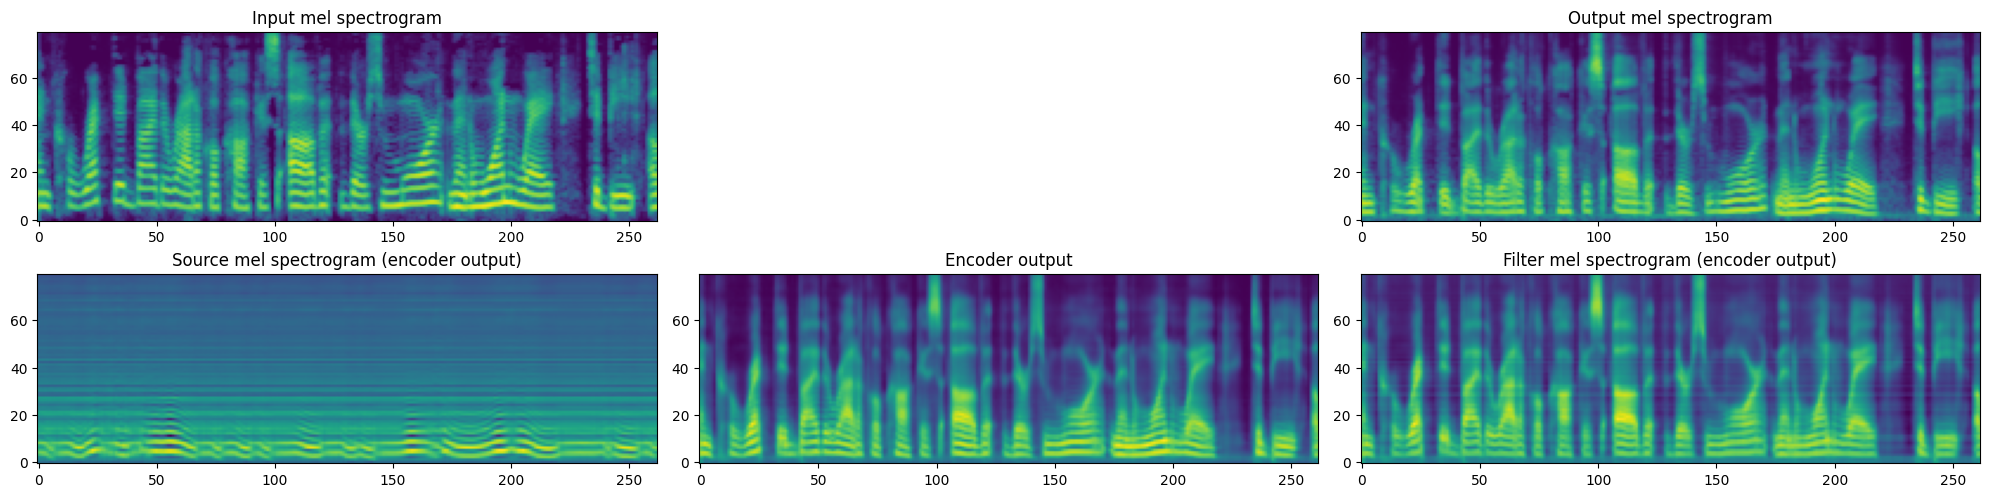

In [98]:
plot_model_output(x, n_frames,"vc_xlsr", t, t_n_frames)

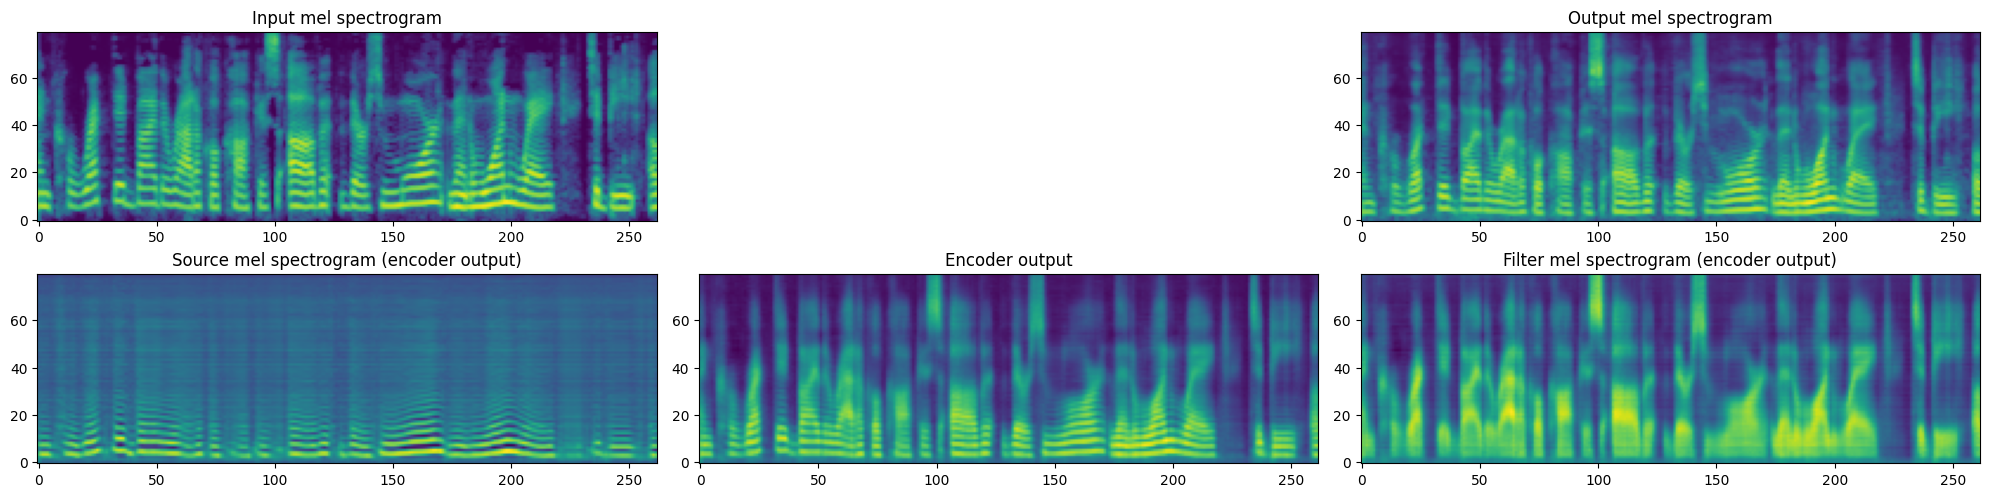

In [102]:
plot_model_output(x, n_frames,"evc_xlsr_yin", t, t_n_frames, pitch_shift=True)

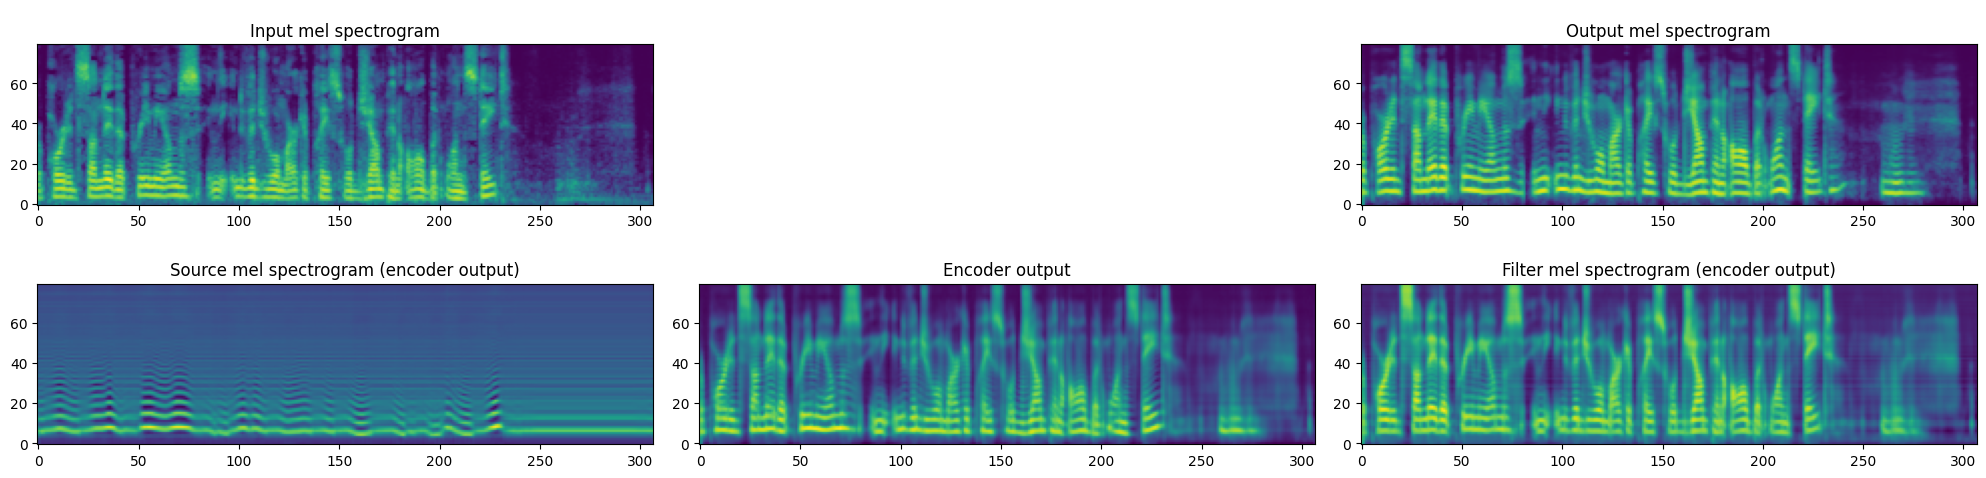

In [103]:
plot_model_output(t, t_n_frames,"vc_xlsr", x, n_frames)

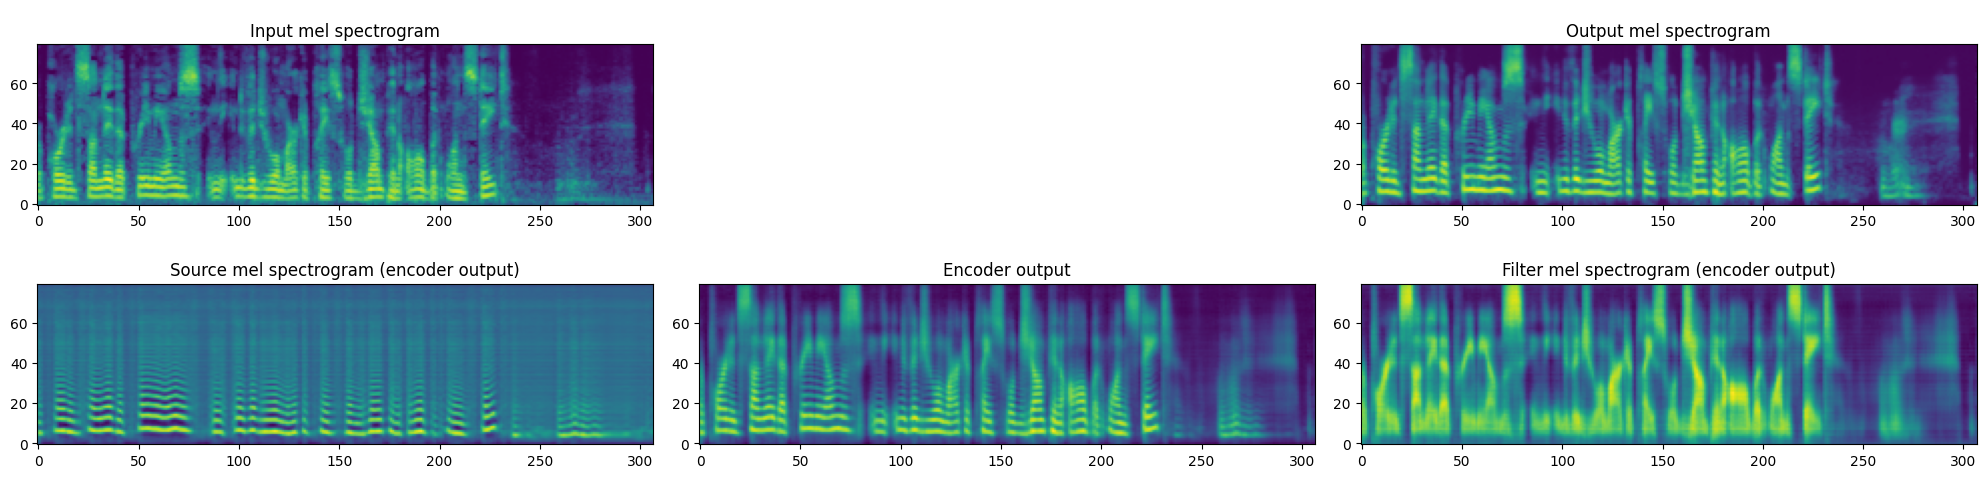

In [104]:
plot_model_output(t, t_n_frames,"evc_xlsr_yin", x, n_frames, pitch_shift=True)